In [84]:
from openpiv import windef
# from openpiv.piv import simple_piv
    
from openpiv import tools, scaling, validation, filters, preprocess
import openpiv.pyprocess as process
from openpiv import pyprocess
import numpy as np
import pathlib
import warnings
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

In [106]:
def remove_noise(binarized_image_path, output, input_text=None, VISUALIZE=True):
    # Load the binarized image (0 for background, 255 for blobs)
    binarized_image = cv2.imread(binarized_image_path, cv2.IMREAD_GRAYSCALE)

    # Find blobs using connected components
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(binarized_image)

    # Create an empty mask to store the result
    result = np.zeros_like(binarized_image)

    # Iterate through each connected component (except the background)
    for label in range(1, retval):
        # Extract the area of the blob
        area = stats[label, cv2.CC_STAT_AREA]

        # Check if the area is greater than or equal to 3 pixels
        if area >= 3:
            # If the area is greater than or equal to 3, keep it in the result
            result[labels == label] = 255

            if input_text is not None:
                # Add an identifier to the blob using input_text
                cv2.putText(result, input_text, (50,90),
                            cv2.FONT_HERSHEY_SIMPLEX, 3, 255, 10)

    # Save the resulting image
    cv2.imwrite(f"{output}.tif", result)

    if VISUALIZE:
        # Display the image using matplotlib
        plt.imshow(result, cmap='gray')
        plt.show()

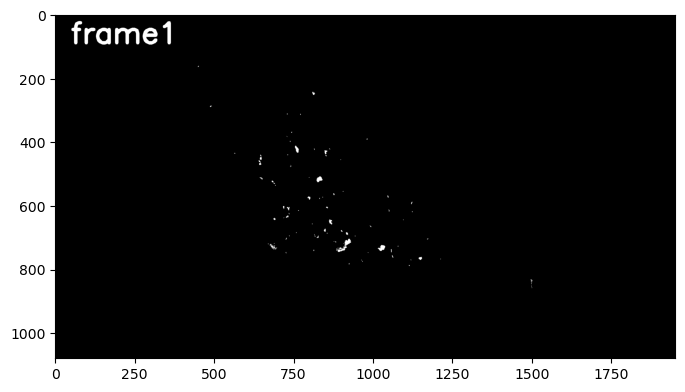

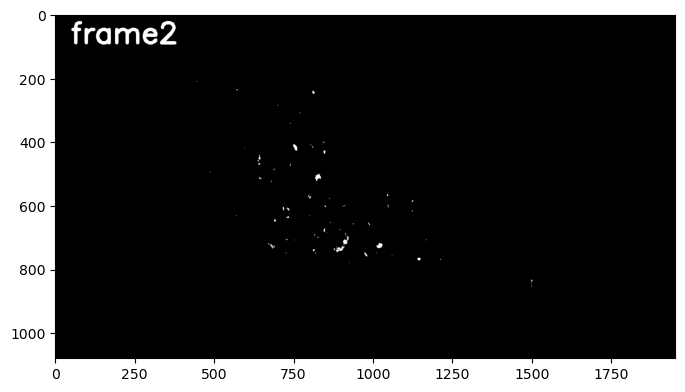

In [107]:
path1 = "C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/external/23-10/HighSpeedCamera/15.23/frames-postprocess-1/132_img1.tif"
path2 = "C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/external/23-10/HighSpeedCamera/15.23/frames-postprocess-1/132_img2.tif"

remove_noise(path1, "test1", "frame1")
remove_noise(path2, "test2", "frame2")

In [89]:
settings = windef.PIVSettings()
settings.filepath_images = pathlib.Path("C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/notebooks/")

In [90]:
def simple_piv(im1, im2, plot=True):
    """
    Simplest PIV run on the pair of images using default settings

    piv(im1,im2) will create a tmp.vec file with the vector filed in pix/dt
    (dt=1) from two images, im1, im2 provided as full path filenames
    (TIF is preferable, whatever imageio can read)

    """
    fig, axs = plt.subplots(2, 1, figsize=(10,10))
    axs[0].imshow(im1, cmap=plt.cm.gray)
    axs[0].set_title("Frame 1")
    axs[1].imshow(im2, cmap=plt.cm.gray)
    axs[1].set_title("Frame 2")
    plt.show()
    if isinstance(im1, str):
        im1 = tools.imread(im1)
        im2 = tools.imread(im2)

    u, v, s2n = pyprocess.extended_search_area_piv(
        im1.astype(np.int32), im2.astype(np.int32), window_size=16,
        overlap=8, search_area_size=24
    )
    x, y = pyprocess.get_coordinates(image_size=im1.shape,
                                     search_area_size=24, overlap=8)

    valid = s2n > np.percentile(s2n, 50)

    if plot:
        _, ax = plt.subplots(figsize=(8, 6))
        ax.imshow(im1, cmap=plt.get_cmap("gray"), alpha=0.5, origin="upper")
        ax.quiver(x[valid], y[valid], u[valid], -v[valid], scale=70,
                  color='r', width=.005)
        plt.show()
        
    # conform with the windef and tools.display_vector_field
    x,y,u,v = tools.transform_coordinates(x,y,u,v)

    return x, y, u, v, s2n


![ezgif.com-gif-maker (3).gif](<https://im2.ezgif.com/tmp/ezgif-2-2012d8946f.gif>)


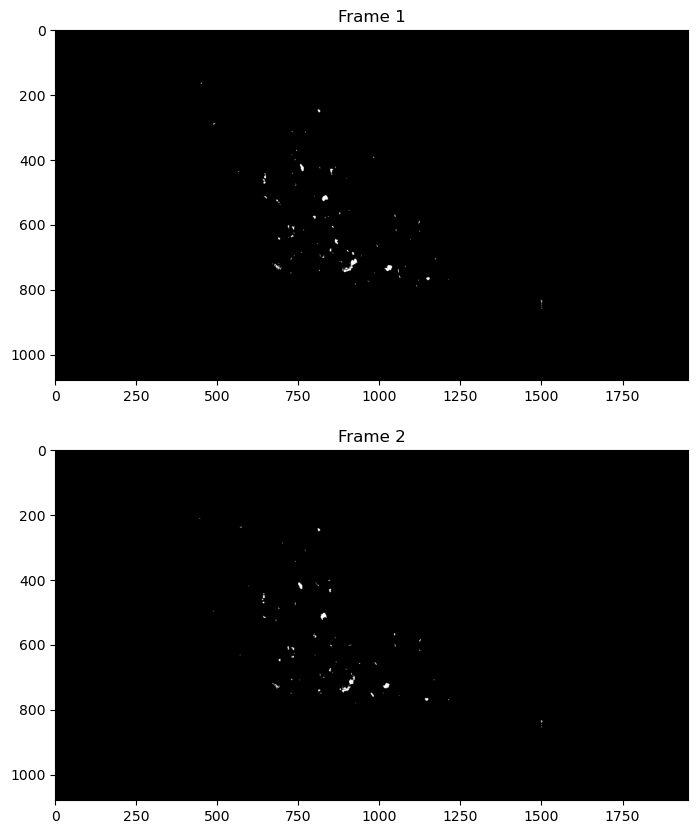

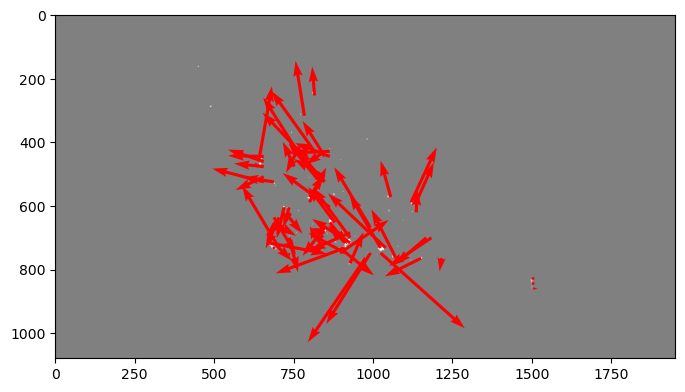

In [91]:
files = sorted(settings.filepath_images.glob('*.tif'))
from openpiv.tools import imread
simple_piv(imread(files[0]), imread(files[1]));

____



pca to the images to reduce the image resolution
